### Описание

Осреднение пластового давления по данным статических замеров

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

%matplotlib inline  
%config InlineBackend.figure_format = 'png'
pd.options.display.max_columns = None

In [2]:
# Фильтр по имени объекта разработки
#OBJ = "J1A"
#OBJ = "J2A"
#OBJ = "J3"
#OBJ = "J7-8"
#OBJ = "J9"
OBJ = "J13"

In [3]:
BASEPATH = "D:/Appraisal/Sitar/NIPI/Turkmenoi/PRESSURE/"
BASEFILENAME = "Well_Prod_History_"
STARTDATE = pd.to_datetime("01.01.2011")
STOPDATE = pd.to_datetime("01.01.2020")
WELL_COL = "WELL"
DATE_COL = "Date"
PRES_COL = "PRESSURE"
MIN_DELAY = 30 # дней - ожидаемое время восстановления пластового давления
MAX_LENGTH = 90 # days - длительность временного интервала для осреднения замеров давления
AVG_FUNC = np.median
EXCLUDE_WELLS = {"J1A": [], "J2A": ["Tur54"], "J3": [], "J7-8": [], "J9": ["Tur46", "Tur51"], "J13": ["Tur46", "Tur56"]}

In [4]:
xl = pd.ExcelFile(BASEPATH+BASEFILENAME+OBJ+".xlsx")

In [5]:
wells = []
for name in xl.sheet_names:
    if name[5:] == "_PRES":
        wells.append(name[:5])

In [6]:
df_pres_dict = {}
df_prod_dict = {}
avg_list = []
for well in wells:
    if well in EXCLUDE_WELLS[OBJ]:
        continue
    
    PRES_SHEET = well + "_PRES"
    
    if well+"_PROD" in xl.sheet_names:
        HIST_SHEET = well+"_PROD"
        RATE_COL = "LIQ_RATE"
    else:
        HIST_SHEET = well+"_INJ"
        RATE_COL = "INJ_RATE"
        
    df_pres = xl.parse(PRES_SHEET)
    df_pres_dict[well] = df_pres
    
    df_prod = xl.parse(HIST_SHEET)  
    df_prod_dict[well] = df_prod
    
    downtime_intervals = []
    int_start = None
    cur_date = None
    cur_value = None
    df_slice = df_prod.loc[(df_prod[DATE_COL] >= STARTDATE) & (df_prod[DATE_COL] < STOPDATE), [DATE_COL, RATE_COL]]
    cnt = -1
    slice_len = len(df_slice)
    for index, row in df_slice.iterrows():
        cnt += 1
        prev_date = cur_date
        prev_value = cur_value
        
        cur_date = row["Date"]
        cur_value = row[RATE_COL]
        
        if int_start is None:
            if (cur_value > 0) & (prev_value is None):
                continue
            if (cur_value == 0) & (prev_value is None):
                delay_start = cur_date
                continue
            elif (cur_value == 0) & (prev_value > 0):
                delay_start = cur_date
                continue
            elif (cur_value == 0) & (prev_value == 0):
                delay_length = (cur_date - delay_start).days
                if delay_length >= MIN_DELAY:
                    int_start = cur_date
        else:
            if (cur_value > 0) & (prev_value == 0):
                interval = (int_start, prev_date)
                downtime_intervals.append(interval)
                int_start = None
                continue
                
            int_length = (cur_date - int_start).days    
            if (int_length >= MAX_LENGTH) | (cnt == (slice_len - 1)):
                interval = (int_start, prev_date)
                downtime_intervals.append(interval)
                int_start = cur_date
    
    avg_pressures = []
    for interval in downtime_intervals:
        int_start, int_stop = interval
        avg_pressure = df_pres.loc[(df_pres[DATE_COL] >= int_start) & (df_pres[DATE_COL] < int_stop), PRES_COL].agg(AVG_FUNC)
        if not np.isnan(avg_pressure):
            int_middle = int_start + pd.to_timedelta((int_stop - int_start).days // 2, "d")
            avg_pressures.append((int_middle, avg_pressure))
    
    for val in avg_pressures:
        avg_list.append((well, val[0], val[1]))

In [7]:
def ScatterPlot(df_plot, x_param, y_param, color_param, _xlim=None, _ylim=None, 
                title=None, x_label=None, y_label=None, cmap_name="gist_rainbow"):
    cmap = mpl.cm.get_cmap(cmap_name)
    sm = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=cmap)

    categories = np.unique(df_plot[color_param])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors)) 
    colors = df_plot[color_param].apply(lambda x: colordict[x])
    patches = [mpatches.Patch(color=sm.to_rgba(colordict[cat]), label=cat) for cat in colordict]
    
    if x_label is None: x_label = x_param
    if y_label is None: y_label = y_param
    
    plt.scatter(df_plot[x_param], df_plot[y_param], c=colors, s=30, cmap=cmap)
    if _xlim is not None: plt.xlim(_xlim)
    if _ylim is not None: plt.ylim(_ylim)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.legend(handles=patches, loc='upper center', bbox_to_anchor=(1.5, 1.1), shadow=True, ncol=1)
    plt.grid(True)
    plt.show()

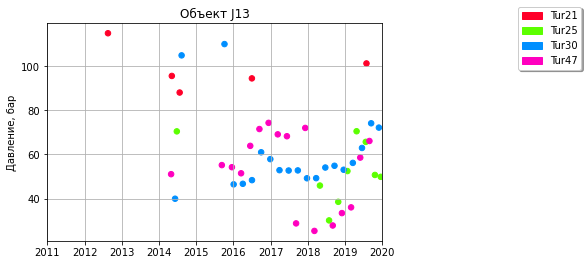

In [8]:
df_plot = pd.DataFrame(avg_list, columns=[WELL_COL, DATE_COL, PRES_COL])
ScatterPlot(df_plot, DATE_COL, PRES_COL, WELL_COL, x_label="", y_label="Давление, бар",
            title="Объект "+OBJ, _xlim=(pd.to_datetime("01.01.2011"), pd.to_datetime("01.01.2020")))

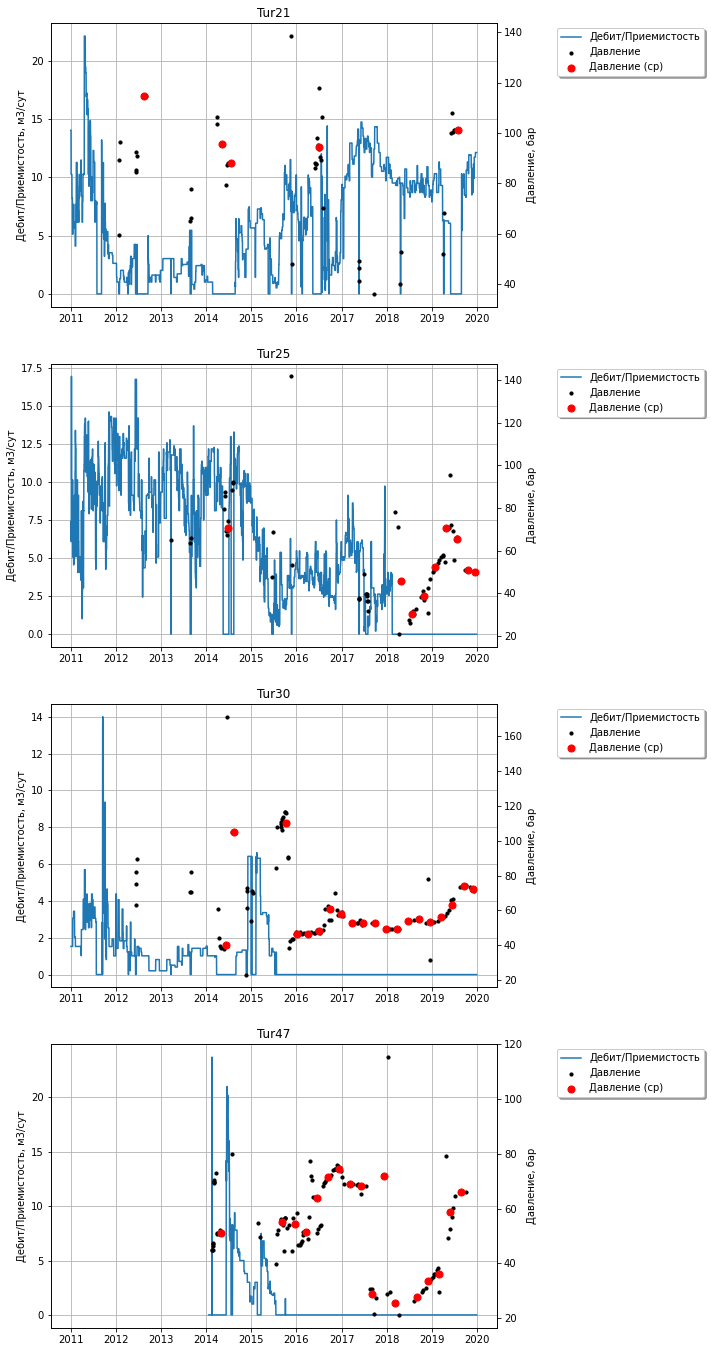

In [9]:
plot_wells = np.unique(df_plot[WELL_COL])
well_cnt = len(plot_wells)

fig, axs = plt.subplots(well_cnt, sharex=True, figsize=(8, 6*well_cnt))
for index, well in enumerate(plot_wells):
    if well+"_PROD" in xl.sheet_names:
        RATE_COL = "LIQ_RATE"
    else:
        RATE_COL = "INJ_RATE"
        
    df_pres = df_pres_dict[well]
    df_prod = df_prod_dict[well]
    
    ax1 = axs[index]
    #ax1.set_ylim(0)
    ax1.set_ylabel("Дебит/Приемистость, м3/сут")
    ax1.xaxis.set_tick_params(labelbottom=True)
    ax1.grid(True)

    x = df_prod.loc[(df_prod[DATE_COL] >= STARTDATE) & (df_prod[DATE_COL] < STOPDATE), DATE_COL]
    y = df_prod.loc[(df_prod[DATE_COL] >= STARTDATE) & (df_prod[DATE_COL] < STOPDATE), RATE_COL]
    l1, = ax1.plot(x, y, label="Дебит/Приемистость")

    ax2 = ax1.twinx()
    #ax2.set_ylim(0)
    ax2.set_ylabel("Давление, бар")
    
    x = df_pres.loc[(df_pres[DATE_COL] >= STARTDATE) & (df_pres[DATE_COL] < STOPDATE), DATE_COL]
    y = df_pres.loc[(df_pres[DATE_COL] >= STARTDATE) & (df_pres[DATE_COL] < STOPDATE), PRES_COL]
    l2 = ax2.scatter(x, y, c='black', s=10, label="Давление")
    
    x = df_plot.loc[(df_plot[WELL_COL] == well), DATE_COL]
    y = df_plot.loc[(df_plot[WELL_COL] == well), PRES_COL]
    l3 = ax2.scatter(x, y, c='red', s=50, label="Давление (ср)")    
    
    #plt.grid(True)
    plt.title(well)
    plt.legend(handles=(l1, l2, l3), loc='upper center', bbox_to_anchor=(1.3, 1.0), shadow=True, ncol=1)
    

plt.show()

In [10]:
df_plot.to_csv(BASEPATH+"Avg_Pressure_"+OBJ+".csv", index=False)